# 7.7 Expectation-Maximization (EM)

## Problem 1
Expectation Maximization (EM) falls under unsupervised learning. But what specific kind of unsupervised learning setting would you use it for? Put differently, you could use both K-Means and EM for clustering, but when will you pick EM over K-Means?<p>
<b>Answer</b>
You will pick EM over K-Means in the following situations:
1. Data with missing information: The EM algorithm can naturally incorporate missing data by treating the missing values as unobserved latent variables. The core idea is to estimate the parameters of the underlying model while simultaneously inferring the likely values of the missing data. The algorithm calculates the expected values of the latent variables, which includes the missing data points. It essentially "fills in" the missing values with their most probable estimates based on the current model. A good real life example of this is when the manufacturer of a consumer product only has limited direct to consumer sales information, e.g. most Nike shoes are sold through distribution, and while Nike might have some of that B2C data, a lot of it might be missing. EM can help estimate the data.

2. When the clusters of your data have significantly different shapes, sizes, densities, and orientations. K-Means picks random, evenly distributed centroids and is good at identifying clusters that look similar. EM is better at identifying clusters that are highly irregular or distinct from each other. A good real life example of this is a computer vision model that is trying to interpret a photograph that could include people, trees, grass, mountains, road, etc. Each of these elements has a very different characteristic of size, shape and color. EM can help discern between people and trees or grass and a road.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.metrics import silhouette_score, euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.optimize import linear_sum_assignment

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
df = pd.read_csv('Assignment 7 data-lifecyclesaving.csv')
print(df.columns)
display(df.head(222))

Index(['Contry', 'sr', 'pop15', 'pop75', 'dpi', 'ddpi'], dtype='object')


,Contry,sr,pop15,pop75,dpi,ddpi
0,Australia,11.43,29.35,2.87,2329.68,2.87
1,Austria,12.07,23.32,4.41,1507.99,3.93
2,Belgium,13.17,23.80,4.43,2108.47,3.82
3,Bolivia,5.75,41.89,1.67,189.13,0.22
4,Brazil,12.88,42.19,0.83,728.47,4.56
5,Canada,8.79,31.72,2.85,2982.88,2.43
6,Chile,0.60,39.74,1.34,662.86,2.67
7,China,11.90,44.75,0.67,289.52,6.51
8,Colombia,4.98,46.64,1.06,276.65,3.08
9,Costa Rica,10.78,47.64,1.14,471.24,2.80


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Contry  50 non-null     object 
 1   sr      50 non-null     float64
 2   pop15   50 non-null     float64
 3   pop75   50 non-null     float64
 4   dpi     50 non-null     float64
 5   ddpi    50 non-null     float64
dtypes: float64(5), object(1)
memory usage: 2.5+ KB


In [7]:
df.columns = ['country', 'savings', 'pop_under_15', 'pop_over_75', 'disp_income', 'disp_income_growth']
display(df)

,country,savings,pop_under_15,pop_over_75,disp_income,disp_income_growth
0,Australia,11.43,29.35,2.87,2329.68,2.87
1,Austria,12.07,23.32,4.41,1507.99,3.93
2,Belgium,13.17,23.80,4.43,2108.47,3.82
3,Bolivia,5.75,41.89,1.67,189.13,0.22
4,Brazil,12.88,42.19,0.83,728.47,4.56
5,Canada,8.79,31.72,2.85,2982.88,2.43
6,Chile,0.60,39.74,1.34,662.86,2.67
7,China,11.90,44.75,0.67,289.52,6.51
8,Colombia,4.98,46.64,1.06,276.65,3.08
9,Costa Rica,10.78,47.64,1.14,471.24,2.80


In [8]:
df_sorted_by_income = df.sort_values(by='disp_income', ascending=False).reset_index(drop=True)
display(df_sorted_by_income)

,country,savings,pop_under_15,pop_over_75,disp_income,disp_income_growth
0,United States,7.56,29.81,3.43,4001.89,2.45
1,Sweden,6.86,21.44,4.54,3299.49,3.01
2,Canada,8.79,31.72,2.85,2982.88,2.43
3,Switzerland,14.13,23.49,3.73,2630.96,2.70
4,Denmark,16.85,24.42,3.93,2496.53,3.99
5,Germany,12.55,23.31,3.35,2457.12,3.44
6,Luxembourg,10.35,21.80,3.73,2449.39,1.57
7,Australia,11.43,29.35,2.87,2329.68,2.87
8,Norway,10.25,25.95,3.67,2231.03,3.62
9,France,12.64,25.06,4.70,2213.82,4.52


# Problem 2
1. Use EM for clustering “similar” countries.

2. Report how many groups you got and why you chose that number with the help of AIC and BIC. 

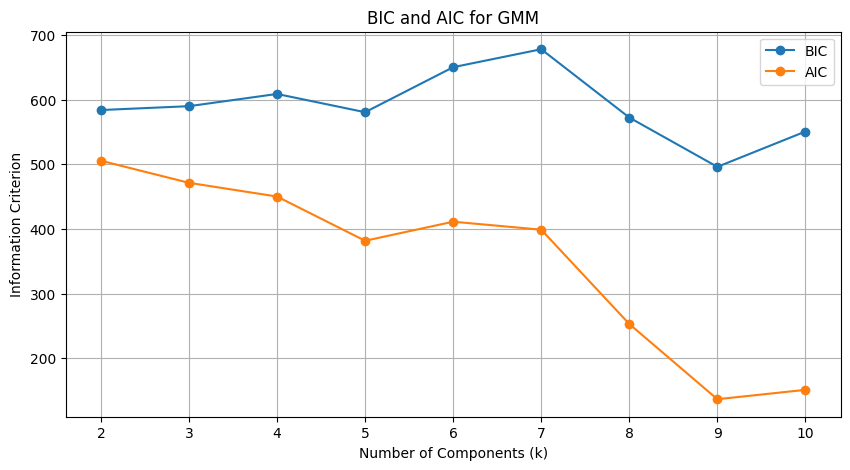

In [9]:
# Look at number of clusters AIC/BIC
# Separate country names and numerical features
country_names = df['country']
numerical_df = df.drop('country', axis=1)
feature_names = numerical_df.columns
# Scale the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_df)

# Choose the Number of Clusters (using BIC/AIC)
# We'll test a range of possible component numbers
n_components_range = range(2, 11) # Typically start from 2 clusters
bic = []
aic = []

for n_components in n_components_range:
    # Create a GMM model
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    # Fit the model to the scaled data
    gmm.fit(scaled_features)
    # Append BIC and AIC values
    bic.append(gmm.bic(scaled_features))
    aic.append(gmm.aic(scaled_features))

# Plot BIC and AIC
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic, marker='o', label='BIC')
plt.plot(n_components_range, aic, marker='o', label='AIC')
plt.xlabel('Number of Components (k)')
plt.ylabel('Information Criterion')
plt.title('BIC and AIC for GMM')
plt.xticks(n_components_range)
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Picking k=2 and k=9

for k in [2, 9]:
    gmm_final = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm_final.fit(scaled_features)
    cluster_labels = gmm_final.predict(scaled_features)
    # Get the probabilities of each point belonging to each cluster (soft assignment)
    # This is a key output of EM/GMM that K-Means doesn't provide directly
    cluster_probabilities = gmm_final.predict_proba(scaled_features)
    # Add the cluster labels and probabilities back to a DataFrame for analysis
    df[f'cluster_{k}'] = cluster_labels

# --- Analyze Cluster Characteristics for k=2 ---
print("\n--- Analysis for k=2 Clusters ---")
print("\nMean feature values per cluster (k=2):")
display(df.groupby('cluster_2')[feature_names].mean())

# --- Analysis for k=9 ---
print("\n--- Analysis for k=9 Clusters ---")
print("\nMean feature values per cluster (k=9):")
display(df.groupby('cluster_9')[feature_names].mean())

print("--- Countries in each cluster for k=2 ---")
print("-" * 35)
# Group by the 'cluster_2' column and iterate through the groups
for cluster_id, cluster_df in df.groupby('cluster_2'):
    print(f"Cluster {cluster_id}:")
    # Extract the list of country names in this cluster
    country_list = cluster_df['country'].tolist()
    # Print the list of countries
    print(", ".join(country_list))
    print("-" * 35)

print("\n--- Countries in each cluster for k=9 ---")
print("-" * 35)
# Group by the 'cluster_9' column and iterate through the groups
for cluster_id, cluster_df in df.groupby('cluster_9'):
    print(f"Cluster {cluster_id}:")
    country_list = cluster_df['country'].tolist()
    print(", ".join(country_list))
    print("-" * 35)


--- Analysis for k=2 Clusters ---

Mean feature values per cluster (k=2):


,savings,pop_under_15,pop_over_75,disp_income,disp_income_growth
cluster_2,,,,,
0,7.410870,44.304783,1.099565,336.049130,3.722609
1,11.596296,27.239630,3.309630,1763.288519,3.787407



--- Analysis for k=9 Clusters ---

Mean feature values per cluster (k=9):


,savings,pop_under_15,pop_over_75,disp_income,disp_income_growth
cluster_9,,,,,
0,1.270000,34.030000,3.080000,1900.100000,1.120000
1,10.363333,45.520000,0.996667,359.680000,1.788333
2,12.320909,24.390000,3.887273,2148.083636,3.273636
3,8.305000,42.405000,1.900000,252.025000,13.470000
4,10.867143,29.291429,2.957143,1052.287143,3.395714
5,4.026667,44.074167,1.120833,325.890000,2.645000
6,15.930000,28.305000,2.620000,1044.635000,7.867500
7,7.736667,27.656667,3.606667,3428.086667,2.630000
8,14.160000,41.027500,0.895000,351.820000,4.552500


--- Countries in each cluster for k=2 ---
-----------------------------------
Cluster 0:
Bolivia, Brazil, Chile, China, Colombia, Costa Rica, Ecuador, Guatamala, Honduras, India, Korea, Nicaragua, Panama, Paraguay, Peru, Philippines, Turkey, Tunisia, Venezuela, Zambia, Jamaica, Libya, Malaysia
-----------------------------------
Cluster 1:
Australia, Austria, Belgium, Canada, Denmark, Finland, France, Germany, Greece, Iceland, Ireland, Italy, Japan, Luxembourg, Malta, Norway, Netherlands, New Zealand, Portugal, South Africa, South Rhodesia, Spain, Sweden, Switzerland, United Kingdom, United States, Uruguay
-----------------------------------

--- Countries in each cluster for k=9 ---
-----------------------------------
Cluster 0:
Iceland
-----------------------------------
Cluster 1:
Costa Rica, Honduras, India, Peru, Philippines, Venezuela
-----------------------------------
Cluster 2:
Australia, Austria, Belgium, Denmark, France, Germany, Italy, Luxembourg, Norway, Switzerland, Unite

## Problem 2 Answers

I chose k=2 because that is the lowest number of clusters BIC before it increases, however, after k=2, the BIC goes up and then back down again so I chose k=9 being the lowest of the graph. I then compared these two models.<p>
k=2: This solution provides a very high-level view, splitting the data into two broad groups. Looking at the mean values, Cluster 0 seems to represent countries with generally lower savings, younger populations, lower old-age populations, lower disposable income, and slightly higher income growth. Cluster 1 appears to represent countries with higher savings, older populations, higher old-age populations, higher disposable income, and lower income growth. These two clusters might broadly correspond to different stages of economic development or demographic profiles. This level of segmentation is very easy to understand and communicate. For k=2, the clusters are reasonably balanced. It is concerning that so many countries of significantly different life-cycle savings attributes are clustered together; for example Venezuela, does not belong in the same cluster as India having radically different levels of wealth.<p>
    
k=9: This solution provides a much finer-grained view. There are 9 different groups, some potentially very small. Analyzing the mean values for 9 clusters is more complex. Each cluster represents a more specific combination of the features. For example, you might find clusters representing "High Income, Low Growth, Old Population," "Low Income, High Growth, Young Population," "Moderate Income, High Savings," etc. While this provides more detail about the data structure, distinguishing and interpreting 9 distinct profiles can be challenging.<p>
For k=9, the cluster sizes are much more varied, with some clusters having very few countries (e.g., clusters 0, 3, 4, 7, 8 in our sample data have less than 5 countries each). Very small clusters might represent outliers or very specific niches, but they can also be less statistically robust.<p>
Based on my analysis and the BIC score, k=9 is the better choice as it represents a significantly better statistical fit to the data's distribution within the tested range. This is the most statistically accurate model that describes the underlying probability distribution of the data, capturing finer structures.